<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2023/blob/main/notebooks/es6/AML_2023_HandsOn_6_YOLO_part_II_ipynb_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this lesson we will try to adapt a pytorch version of YOLO to work with a new datast.
We can no retrain the network on colab, but I will show you all the step that we need to do.
[DATASET](https://datasets.simula.no/kvasir-seg/)
The framework I am using can be found on github [GIT](https://github.com/eriklindernoren/PyTorch-YOLOv3)

to download the dataset you can use !wget with this link
https://datasets.simula.no/downloads/kvasir-seg.zip

and you will need to extract the files using !unzip like in HandsOn 2

You can find a reduced version of the dataset in this drive folder [FOLDER](https://drive.google.com/drive/folders/1mMH4pgRHiONJjERnoH3lGV2n91iszARD?usp=sharing) 

In [1]:
import json
from google.colab import drive
import os
drive.mount('/content/gdrive/', force_remount=True)

import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os
import time

import matplotlib.pyplot as plt

from typing import List, Tuple

Mounted at /content/gdrive/


## I started hating google drive so I switched to absolute paths to avoid getting frustrated with error 107.
Please, use your own paths that may be different from mine


In [2]:
f = open('/content/gdrive/MyDrive/Yolo_v3/Kvasir/kavsir_bboxes.json')
data = json.load(f)

In [3]:
def CreateDir(path):
	# Create a directory if it does not exist
	success = os.path.exists(path)
	if not success:
		os.makedirs(path)
CreateDir("/content/gdrive/MyDrive/Yolo_v3/Kvasir/data/Kvasir-SEG/labels")# or whatever you like 
labeldir="/content/gdrive/MyDrive/Yolo_v3/Kvasir/data/Kvasir-SEG/labels"
imagedir="/content/gdrive/MyDrive/Yolo_v3/Kvasir/data/Kvasir-SEG/images"

In [4]:
data['cju7f0ec32txj08184asb8w5f']# this is an example label, a  bbox is given as the vertex of the rectangle, we need to convert it to the yolo anchor format

{'height': 445,
 'width': 604,
 'bbox': [{'label': 'polyp',
   'xmin': 265,
   'ymin': 190,
   'xmax': 412,
   'ymax': 345}]}

In [5]:

def xyxy2xcycwh(xmin,xmax,ymin,ymax,oh,ow):# from bounding box to yolo anchors
  xc = (xmax-xmin)/2. + xmin# get center of anchor
  yc = (ymax-ymin)/2. + ymin 

  w = (xmax-xmin)
  h = (ymax-ymin)
  # scale coordinates in [0,1]
  xc =xc/ow
  yc = yc/oh
  w = w/ow
  h = h/oh
  
  return xc,yc,w,h

In [6]:
# the data folder will be an images folder with all the images in jpg format and a labels folder with the list of the bboxes in txt format

In [7]:
#json to txt files with yolo bboxes TODO-> we can read the dictionary directly in the data generator?
bbox_size = []
if True:#I have already execute this part and it is slow on Colab
  for k in data.keys():# from json to txt label (input for yolo custom train)
    oh = data[k]["height"]
    ow = data[k]["width"]
    bbs=data[k]["bbox"]
    if False:# to write files
      with open(labeldir+"/"+k+".txt", 'w') as f:
        for bb in bbs:
          xmin = bb["xmin"]
          xmax = bb["xmax"]
          ymin = bb["ymin"]
          ymax = bb["ymax"]

          xc,yc,w,h = xyxy2xcycwh(xmin,xmax,ymin,ymax,oh,ow)
          f.write("0 {} {} {} {}".format(xc,yc,w,h))#first one is class (only one)
          f.write("\n")
          bbox_size.append([w,h])
        f.close()
    else:
      for bb in bbs:
          xmin = bb["xmin"]
          xmax = bb["xmax"]
          ymin = bb["ymin"]
          ymax = bb["ymax"]
          xc,yc,w,h = xyxy2xcycwh(xmin,xmax,ymin,ymax,oh,ow)
          bbox_size.append([w,h])
  

In [8]:
bbox_size = np.array(bbox_size)# this is the distribution of boxes sizes, it will be useful

In [9]:
# this is a check to see if we have matched pair image/labels
labels = os.listdir(labeldir)
labels.sort()
imgs = os.listdir(imagedir)
imgs.sort()
print(len(labels))
print(len(imgs))
np.sum([a[0:5]==b[0:5] for a,b in zip(imgs,labels)])/len(labels)#this shold be one if each image has a label

1000
1000


1.0

In [10]:
# we want to reserve 100 image for validation.
# train file are list of lile paths, our generator will read a image file and a label file and will transform them to pyTorch tensors
fullpathlabels = [os.path.join(labeldir,i) for i in labels]
fullpathimages = [os.path.join(imagedir,i) for i in imgs]
train_img = fullpathimages[:-100]
vali_img = fullpathimages[-100:]
train_label = fullpathlabels[:-100]
vali_label = fullpathlabels[-100:]
print("train : ",len(train_img))
print("vali : ",len(vali_img))

train :  900
vali :  100


In [11]:
def parse_cfg(path):# read the model configuration and parse it as a python readable variable
    """Parses the yolo-v3 layer configuration file and returns module definitions"""
    file = open(path, 'r')
    lines = file.read().split('\n')
    lines = [x for x in lines if x and not x.startswith('#')]
    lines = [x.rstrip().lstrip() for x in lines]  # get rid of fringe whitespaces
    module_defs = []
    for line in lines:
        if line.startswith('['):  # This marks the start of a new block
            module_defs.append({})
            module_defs[-1]['type'] = line[1:-1].rstrip()
            if module_defs[-1]['type'] == 'convolutional':
                module_defs[-1]['batch_normalize'] = 0
        else:
            key, value = line.split("=")
            value = value.strip()
            module_defs[-1][key.rstrip()] = value.strip()

    return module_defs



In [12]:
# read the configuration file
config = parse_cfg("/content/gdrive/MyDrive/Yolo_v3/working/yolov3.cfg")


In [13]:
print(config[1:3])# we will find the list of block in the yolo neural net. We will need to modify it to work with the new dataset

[{'type': 'convolutional', 'batch_normalize': '1', 'filters': '32', 'size': '3', 'stride': '1', 'pad': '1', 'activation': 'leaky'}, {'type': 'convolutional', 'batch_normalize': '1', 'filters': '64', 'size': '3', 'stride': '2', 'pad': '1', 'activation': 'leaky'}]


[yolo]

mask = 6,7,8

anchors = 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326
classes=80

num=9

jitter=.3

ignore_thresh = .7

truth_thresh = 1

random=1


In [14]:
#this your YOLO configuration layer. It takes some defined anchors (defined by masks) for each resolution

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


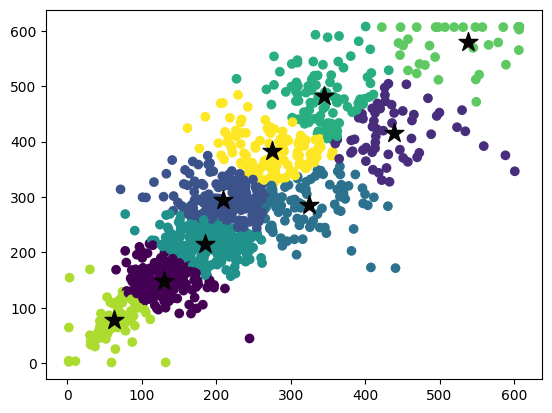

In [15]:
# we need to specialize the anchors at our dataset
# we did not check an important part. We left the default anchors
from sklearn.cluster import KMeans
X = bbox_size
kmeans = KMeans(n_clusters=9)
kmeans.fit(X)

# Get the centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Plot the data points and centroids
plt.scatter(X[:, 0]*608, X[:, 1]*608, c=labels)
plt.scatter(centroids[:, 0]*608, centroids[:, 1]*608, marker='*', s=200, c='#050505')
plt.show()

In [16]:
print(str(np.sort((centroids*608).astype("int"),axis=0)).replace("[","").replace("]","").replace("  ",",").replace("  ",",").replace("\n",",   "))

 62,77,    129 148,    184 215,    209 285,    274 295,    324 382,    344 415,    438 481,    538 580


In [17]:
# I wanted to du in one line but i couldn't
new_anchors = "62,77,    128,151,    189,213,    194,287,    288,300,    298,391,    355,394,    444,490,    538,580"

In [18]:
########## modify the configuration file
#--> we have now 1 class
#-> we now have 5+1 property for each box
# --> our anchors are now different since the "average" size of the object is different
for i in range(len(config)):#modify classes
  if config[i]["type"]=="yolo":# 3 end blocks, the 3 scales at witch the bbox is predicted
    config[i]["classes"] = 1
    print(config[i]["classes"])
    print(config[i]["anchors"])
  if config[i]["type"]=="convolutional":# modify the last convolution so it fit the new output
    if config[i]["activation"]=="linear":# we use the fact that the last layer has linear activation to find it
      config[i]["filters"] = 3*(5+1)# so the reshape can give the correct output (this is the number of channels of the last conv layer N_anchors*(bbox properties + classes)

 # remember that a bbox is definet as x center, y center, width, heigth, probability to be an objec. probability to be in a class 

1
10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326
1
10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326
1
10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326


In [19]:
from itertools import chain
import copy# we are passing a dict for building the model, we don't want to modify it inside the function so we will pass a copy instead
def create_modules(module_defs: List[dict]) -> Tuple[dict, nn.ModuleList]:
    """
    Constructs module list of layer blocks from module configuration in module_defs
    :param module_defs: List of dictionaries with module definitions
    :return: Hyperparameters and pytorch module list
    """
    hyperparams = module_defs.pop(0)
    hyperparams.update({
        'batch': int(hyperparams['batch']),
        'subdivisions': int(hyperparams['subdivisions']),
        'width': int(hyperparams['width']),
        'height': int(hyperparams['height']),
        'channels': int(hyperparams['channels']),
        'optimizer': hyperparams.get('optimizer'),
        'momentum': float(hyperparams['momentum']),
        'decay': float(hyperparams['decay']),
        'learning_rate': float(hyperparams['learning_rate']),
        'burn_in': int(hyperparams['burn_in']),
        'max_batches': int(hyperparams['max_batches']),
        'policy': hyperparams['policy'],
        'lr_steps': list(zip(map(int,   hyperparams["steps"].split(",")),
                             map(float, hyperparams["scales"].split(","))))
    })
    assert hyperparams["height"] == hyperparams["width"], \
        "Height and width should be equal! Non square images are padded with zeros."
    output_filters = [hyperparams["channels"]]
    module_list = nn.ModuleList()
    for module_i, module_def in enumerate(module_defs):
        modules = nn.Sequential()

        if module_def["type"] == "convolutional":
            bn = int(module_def["batch_normalize"])
            filters = int(module_def["filters"])
            kernel_size = int(module_def["size"])
            pad = (kernel_size - 1) // 2
            modules.add_module(
                f"conv_{module_i}",
                nn.Conv2d(
                    in_channels=output_filters[-1],
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=int(module_def["stride"]),
                    padding=pad,
                    bias=not bn,
                ),
            )
            if bn:
                modules.add_module(f"batch_norm_{module_i}",
                                   nn.BatchNorm2d(filters, momentum=0.1, eps=1e-5))
            if module_def["activation"] == "leaky":
                modules.add_module(f"leaky_{module_i}", nn.LeakyReLU(0.1))
            elif module_def["activation"] == "mish":
                modules.add_module(f"mish_{module_i}", nn.Mish())
            elif module_def["activation"] == "logistic":
                modules.add_module(f"sigmoid_{module_i}", nn.Sigmoid())
            elif module_def["activation"] == "swish":
                modules.add_module(f"swish_{module_i}", nn.SiLU())

        elif module_def["type"] == "maxpool":
            kernel_size = int(module_def["size"])
            stride = int(module_def["stride"])
            if kernel_size == 2 and stride == 1:
                modules.add_module(f"_debug_padding_{module_i}", nn.ZeroPad2d((0, 1, 0, 1)))
            maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride,
                                   padding=int((kernel_size - 1) // 2))
            modules.add_module(f"maxpool_{module_i}", maxpool)

        elif module_def["type"] == "upsample":
            upsample = Upsample(scale_factor=int(module_def["stride"]), mode="nearest")
            modules.add_module(f"upsample_{module_i}", upsample)

        elif module_def["type"] == "route":
            layers = [int(x) for x in module_def["layers"].split(",")]
            filters = sum([output_filters[1:][i] for i in layers]) // int(module_def.get("groups", 1))
            modules.add_module(f"route_{module_i}", nn.Sequential())

        elif module_def["type"] == "shortcut":
            filters = output_filters[1:][int(module_def["from"])]
            modules.add_module(f"shortcut_{module_i}", nn.Sequential())

        elif module_def["type"] == "yolo":
            anchor_idxs = [int(x) for x in module_def["mask"].split(",")]# we are taking 3 munbers in mask
            # Extract anchors
            anchors = [int(x) for x in module_def["anchors"].split(",")]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]# putting togheter in pairs
            anchors = [anchors[i] for i in anchor_idxs]# selecting the 3 indexes
            num_classes = int(module_def["classes"])
            new_coords = bool(module_def.get("new_coords", False))
            # Define detection layer
            yolo_layer = YOLOLayer(anchors, num_classes, new_coords)
            modules.add_module(f"yolo_{module_i}", yolo_layer)
        # Register module list and number of output filters
        module_list.append(modules)
        output_filters.append(filters)

    return hyperparams, module_list


class Upsample(nn.Module):
    """ nn.Upsample is deprecated """

    def __init__(self, scale_factor, mode: str = "nearest"):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        return x


class YOLOLayer(nn.Module):
    """Detection layer"""

    def __init__(self, anchors: List[Tuple[int, int]], num_classes: int, new_coords: bool):
        """
        Create a YOLO layer
        :param anchors: List of anchors
        :param num_classes: Number of classes
        :param new_coords: Whether to use the new coordinate format from YOLO V7
        """
        super(YOLOLayer, self).__init__()
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.new_coords = new_coords
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()
        self.no = num_classes + 5  # number of outputs per anchor
        self.grid = torch.zeros(1)  # TODO

        anchors = torch.tensor(list(chain(*anchors))).float().view(-1, 2)
        self.register_buffer('anchors', anchors)
        self.register_buffer(
            'anchor_grid', anchors.clone().view(1, -1, 1, 1, 2))
        self.stride = None

    def forward(self, x: torch.Tensor, img_size: int) -> torch.Tensor:
        """
        Forward pass of the YOLO layer
        :param x: Input tensor
        :param img_size: Size of the input image
        """
        stride = img_size // x.size(2)
        self.stride = stride
        bs, _, ny, nx = x.shape  # x(bs,255,20,20) to x(bs,3,20,20,85)
        x = x.view(bs, self.num_anchors, self.no, ny, nx).permute(0, 1, 3, 4, 2).contiguous()

        if not self.training:  # inference
            if self.grid.shape[2:4] != x.shape[2:4]:
                self.grid = self._make_grid(nx, ny).to(x.device)

            if self.new_coords:
                x[..., 0:2] = (x[..., 0:2] + self.grid) * stride  # xy
                x[..., 2:4] = x[..., 2:4] ** 2 * (4 * self.anchor_grid) # wh
            else:
                x[..., 0:2] = (x[..., 0:2].sigmoid() + self.grid) * stride  # xy
                x[..., 2:4] = torch.exp(x[..., 2:4]) * self.anchor_grid # wh
                x[..., 4:] = x[..., 4:].sigmoid() # conf, cls
            x = x.view(bs, -1, self.no)

        return x

    @staticmethod
    def _make_grid(nx: int = 20, ny: int = 20) -> torch.Tensor:
        """
        Create a grid of (x, y) coordinates
        :param nx: Number of x coordinates
        :param ny: Number of y coordinates
        """
        yv, xv = torch.meshgrid([torch.arange(ny), torch.arange(nx)], indexing='ij')
        return torch.stack((xv, yv), 2).view((1, 1, ny, nx, 2)).float()


class Darknet(nn.Module):
    """YOLOv3 object detection model"""

    def __init__(self, config):
        super(Darknet, self).__init__()
        self.module_defs = copy.deepcopy(config)#parse_model_config(config_path) instead or reading the file we are passing a copy of the dict
        self.hyperparams, self.module_list = create_modules(self.module_defs)
        self.yolo_layers = [layer[0]
                            for layer in self.module_list if isinstance(layer[0], YOLOLayer)]
        self.seen = 0
        self.header_info = np.array([0, 0, 0, self.seen, 0], dtype=np.int32)

    def forward(self, x):
        img_size = x.size(2)
        layer_outputs, yolo_outputs = [], []
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
                x = module(x)
            elif module_def["type"] == "route":
                combined_outputs = torch.cat([layer_outputs[int(layer_i)] for layer_i in module_def["layers"].split(",")], 1)
                group_size = combined_outputs.shape[1] // int(module_def.get("groups", 1))
                group_id = int(module_def.get("group_id", 0))
                x = combined_outputs[:, group_size * group_id : group_size * (group_id + 1)] # Slice groupings used by yolo v4
            elif module_def["type"] == "shortcut":
                layer_i = int(module_def["from"])
                x = layer_outputs[-1] + layer_outputs[layer_i]
            elif module_def["type"] == "yolo":
                x = module[0](x, img_size)
                yolo_outputs.append(x)
            layer_outputs.append(x)
        return yolo_outputs if self.training else torch.cat(yolo_outputs, 1)

    def load_darknet_weights(self, weights_path):
        """Parses and loads the weights stored in 'weights_path'"""

        # Open the weights file
        with open(weights_path, "rb") as f:
            # First five are header values
            header = np.fromfile(f, dtype=np.int32, count=5)
            self.header_info = header  # Needed to write header when saving weights
            self.seen = header[3]  # number of images seen during training
            weights = np.fromfile(f, dtype=np.float32)  # The rest are weights

        # Establish cutoff for loading backbone weights
        cutoff = None
        # If the weights file has a cutoff, we can find out about it by looking at the filename
        # examples: darknet53.conv.74 -> cutoff is 74
        filename = os.path.basename(weights_path)
        if ".conv." in filename:
            try:
                cutoff = int(filename.split(".")[-1])  # use last part of filename
            except ValueError:
                pass

        ptr = 0
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if i == cutoff:
                break
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                if module_def["batch_normalize"]:
                    # Load BN bias, weights, running mean and running variance
                    bn_layer = module[1]
                    num_b = bn_layer.bias.numel()  # Number of biases
                    # Bias
                    bn_b = torch.from_numpy(
                        weights[ptr: ptr + num_b]).view_as(bn_layer.bias)
                    bn_layer.bias.data.copy_(bn_b)
                    ptr += num_b
                    # Weight
                    bn_w = torch.from_numpy(
                        weights[ptr: ptr + num_b]).view_as(bn_layer.weight)
                    bn_layer.weight.data.copy_(bn_w)
                    ptr += num_b
                    # Running Mean
                    bn_rm = torch.from_numpy(
                        weights[ptr: ptr + num_b]).view_as(bn_layer.running_mean)
                    bn_layer.running_mean.data.copy_(bn_rm)
                    ptr += num_b
                    # Running Var
                    bn_rv = torch.from_numpy(
                        weights[ptr: ptr + num_b]).view_as(bn_layer.running_var)
                    bn_layer.running_var.data.copy_(bn_rv)
                    ptr += num_b
                else:
                    # Load conv. bias
                    num_b = conv_layer.bias.numel()
                    conv_b = torch.from_numpy(
                        weights[ptr: ptr + num_b]).view_as(conv_layer.bias)
                    conv_layer.bias.data.copy_(conv_b)
                    ptr += num_b
                # Load conv. weights
                num_w = conv_layer.weight.numel()
                conv_w = torch.from_numpy(
                    weights[ptr: ptr + num_w]).view_as(conv_layer.weight)
                conv_layer.weight.data.copy_(conv_w)
                ptr += num_w

    def save_darknet_weights(self, path, cutoff=-1):
        """
            @:param path    - path of the new weights file
            @:param cutoff  - save layers between 0 and cutoff (cutoff = -1 -> all are saved)
        """
        fp = open(path, "wb")
        self.header_info[3] = self.seen
        self.header_info.tofile(fp)

        # Iterate through layers
        for i, (module_def, module) in enumerate(zip(self.module_defs[:cutoff], self.module_list[:cutoff])):
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                # If batch norm, load bn first
                if module_def["batch_normalize"]:
                    bn_layer = module[1]
                    bn_layer.bias.data.cpu().numpy().tofile(fp)
                    bn_layer.weight.data.cpu().numpy().tofile(fp)
                    bn_layer.running_mean.data.cpu().numpy().tofile(fp)
                    bn_layer.running_var.data.cpu().numpy().tofile(fp)
                # Load conv bias
                else:
                    conv_layer.bias.data.cpu().numpy().tofile(fp)
                # Load conv weights
                conv_layer.weight.data.cpu().numpy().tofile(fp)

        fp.close()


def load_model(model_path, weights_path=None):
    """Loads the yolo model from file.
    :param model_path: Path to model definition file (.cfg)
    :type model_path: str
    :param weights_path: Path to weights or checkpoint file (.weights or .pth)
    :type weights_path: str
    :return: Returns model
    :rtype: Darknet
    """
    device = torch.device("cuda" if torch.cuda.is_available()
                          else "cpu")  # Select device for inference
    model = Darknet(model_path).to(device)

    #model.apply(weights_init_normal)

    # If pretrained weights are specified, start from checkpoint or weight file
    if weights_path:
        if weights_path.endswith(".pth"):
            # Load checkpoint weights
            model.load_state_dict(torch.load(weights_path, map_location=device))
        else:
            # Load darknet weights
            model.load_darknet_weights(weights_path)
    return model

In [20]:
model = load_model(config,"/content/gdrive/MyDrive/Yolo_v3/input/data-for-yolo-v3-kernel/yolov3.weights")

In [21]:
config[0]

{'type': 'net',
 'batch': '64',
 'subdivisions': '16',
 'width': '608',
 'height': '608',
 'channels': '3',
 'momentum': '0.9',
 'decay': '0.0005',
 'angle': '0',
 'saturation': '1.5',
 'exposure': '1.5',
 'hue': '.1',
 'learning_rate': '0.001',
 'burn_in': '1000',
 'max_batches': '500200',
 'policy': 'steps',
 'steps': '400000,450000',
 'scales': '.1,.1'}

In [22]:
out = model(torch.randn(1,3,608,608).float())#this model is returning the grids before the flattening, so 3 achors * 3 scales with (5+1) channels

In [23]:
print("N scales : ",len(out))
print("1st output shape : ", out[0].shape)# batch , anchors, grid(h,w), box attribute+classes
print("2nd output shape : ", out[1].shape)
print("3rd output shape : ", out[2].shape)

N scales :  3
1st output shape :  torch.Size([1, 3, 19, 19, 6])
2nd output shape :  torch.Size([1, 3, 38, 38, 6])
3rd output shape :  torch.Size([1, 3, 76, 76, 6])


In [24]:
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torch
import glob
import random

import warnings

from PIL import Image
from PIL import ImageFile

def pad_to_square(img, pad_value):
    c, h, w = img.shape
    dim_diff = np.abs(h - w)
    # (upper / left) padding and (lower / right) padding
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
    # Determine padding
    pad = (0, 0, pad1, pad2) if h <= w else (pad1, pad2, 0, 0)
    # Add padding
    img = F.pad(img, pad, "constant", value=pad_value)

    return img, pad


def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image


In [25]:
class ImageFolder(Dataset):
    def __init__(self, folder_path, transform=None):
        self.files = sorted(glob.glob("%s/*.*" % folder_path))
        self.transform = transform

    def __getitem__(self, index):

        img_path = self.files[index % len(self.files)]
        img = np.array(
            Image.open(img_path).convert('RGB'),
            dtype=np.uint8)

        # Label Placeholder
        boxes = np.zeros((1, 5))

        # Apply transforms
        if self.transform:
            img, _ = self.transform((img, boxes))

        return img_path, img

    def __len__(self):
        return len(self.files)


class ListDataset(Dataset):
    def __init__(self, list_path, img_size=608, multiscale=False, transform=None):
       # with open(list_path, "r") as file:
        self.img_files = list_path#file.readlines() # modified so a file list is passed directly

        self.label_files = []
        for path in self.img_files:
            image_dir = os.path.dirname(path)
            label_dir = "labels".join(image_dir.rsplit("images", 1))
            assert label_dir != image_dir, \
                f"Image path must contain a folder named 'images'! \n'{image_dir}'"
            label_file = os.path.join(label_dir, os.path.basename(path))
            label_file = os.path.splitext(label_file)[0] + '.txt'
            self.label_files.append(label_file)

        self.img_size = img_size
        self.max_objects = 100
        self.multiscale = multiscale
        self.min_size = self.img_size - 3 * 32
        self.max_size = self.img_size + 3 * 32
        self.batch_count = 0
        self.transform = transform

    def __getitem__(self, index):

        # ---------
        #  Image
        # ---------
        try:

            img_path = self.img_files[index % len(self.img_files)].rstrip()

            img = np.array(Image.open(img_path).convert('RGB'), dtype=np.uint8)
        except Exception:
            print(f"Could not read image '{img_path}'.")
            return

        # ---------
        #  Label
        # ---------
        try:
            label_path = self.label_files[index % len(self.img_files)].rstrip()

            # Ignore warning if file is empty
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                boxes = np.loadtxt(label_path).reshape(-1, 5)
        except Exception:
            print(f"Could not read label '{label_path}'.")
            return

        # -----------
        #  Transform
        # -----------
        if self.transform:
            try:
                img, bb_targets = self.transform((img, boxes))
            except Exception:
                print("Could not apply transform.")
                return
            return img_path, img, bb_targets
        return img_path, img, boxes

    def collate_fn(self, batch):
        self.batch_count += 1

        # Drop invalid images
        batch = [data for data in batch if data is not None]

        paths, imgs, bb_targets = list(zip(*batch))

        # Selects new image size every tenth batch
        if self.multiscale and self.batch_count % 10 == 0:
            self.img_size = random.choice(
                range(self.min_size, self.max_size + 1, 32))

        # Resize images to input shape
        imgs = torch.stack([resize(img, self.img_size) for img in imgs])

        # Add sample index to targets
        for i, boxes in enumerate(bb_targets):
            boxes[:, 0] = i
        bb_targets = torch.cat(bb_targets, 0)

        return paths, imgs, bb_targets

    def __len__(self):
        return len(self.img_files)

In [26]:
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage


import torchvision.transforms as transforms


def xywh2xyxy_np(x):
    y = np.zeros_like(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y


class ImgAug(object):
    def __init__(self, augmentations=[]):
        self.augmentations = augmentations

    def __call__(self, data):
        # Unpack data
        img, boxes = data

        # Convert xywh to xyxy
        boxes = np.array(boxes)
        boxes[:, 1:] = xywh2xyxy_np(boxes[:, 1:])

        # Convert bounding boxes to imgaug
        bounding_boxes = BoundingBoxesOnImage(
            [BoundingBox(*box[1:], label=box[0]) for box in boxes],
            shape=img.shape)

        # Apply augmentations
        img, bounding_boxes = self.augmentations(
            image=img,
            bounding_boxes=bounding_boxes)

        # Clip out of image boxes
        bounding_boxes = bounding_boxes.clip_out_of_image()

        # Convert bounding boxes back to numpy
        boxes = np.zeros((len(bounding_boxes), 5))
        for box_idx, box in enumerate(bounding_boxes):
            # Extract coordinates for unpadded + unscaled image
            x1 = box.x1
            y1 = box.y1
            x2 = box.x2
            y2 = box.y2

            # Returns (x, y, w, h)
            boxes[box_idx, 0] = box.label
            boxes[box_idx, 1] = ((x1 + x2) / 2)
            boxes[box_idx, 2] = ((y1 + y2) / 2)
            boxes[box_idx, 3] = (x2 - x1)
            boxes[box_idx, 4] = (y2 - y1)

        return img, boxes


class RelativeLabels(object):
    def __init__(self, ):
        pass

    def __call__(self, data):
        img, boxes = data
        h, w, _ = img.shape
        boxes[:, [1, 3]] /= w
        boxes[:, [2, 4]] /= h
        return img, boxes


class AbsoluteLabels(object):
    def __init__(self, ):
        pass

    def __call__(self, data):
        img, boxes = data
        h, w, _ = img.shape
        boxes[:, [1, 3]] *= w
        boxes[:, [2, 4]] *= h
        return img, boxes


class PadSquare(ImgAug):
    def __init__(self, ):
        self.augmentations = iaa.Sequential([
            iaa.PadToAspectRatio(
                1.0,
                position="center-center").to_deterministic()
        ])


class ToTensor(object):
    def __init__(self, ):
        pass

    def __call__(self, data):
        img, boxes = data
        # Extract image as PyTorch tensor
        img = transforms.ToTensor()(img)

        bb_targets = torch.zeros((len(boxes), 6))
        bb_targets[:, 1:] = transforms.ToTensor()(boxes)

        return img, bb_targets


class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, data):
        img, boxes = data
        img = F.interpolate(img.unsqueeze(0), size=self.size, mode="nearest").squeeze(0)
        return img, boxes
class DefaultAug(ImgAug):
    def __init__(self, ):
        self.augmentations = iaa.Sequential([
            iaa.Sharpen((0.0, 0.1)),
            iaa.Affine(rotate=(-0, 0), translate_percent=(-0.1, 0.1), scale=(0.8, 1.5)),
            iaa.AddToBrightness((-60, 40)),
            iaa.AddToHue((-10, 10)),
            iaa.Fliplr(0.5),
        ])


class StrongAug(ImgAug):
    def __init__(self, ):
        self.augmentations = iaa.Sequential([
            iaa.Dropout([0.0, 0.01]),
            iaa.Sharpen((0.0, 0.1)),
            iaa.Affine(rotate=(-10, 10), translate_percent=(-0.1, 0.1), scale=(0.8, 1.5)),
            iaa.AddToBrightness((-60, 40)),
            iaa.AddToHue((-20, 20)),
            iaa.Fliplr(0.5),
        ])


AUGMENTATION_TRANSFORMS = transforms.Compose([
    AbsoluteLabels(),
    DefaultAug(),
    PadSquare(),
    RelativeLabels(),
    ToTensor(),
])

DEFAULT_TRANSFORMS = transforms.Compose([
    AbsoluteLabels(),
    PadSquare(),
    RelativeLabels(),
    ToTensor(),
])

In [27]:
datavali = ListDataset(vali_img,multiscale=False,transform=DEFAULT_TRANSFORMS)
datatrain = ListDataset(train_img,multiscale=False,transform=AUGMENTATION_TRANSFORMS)

In [28]:
asd =datavali[0]#test validation dataset 

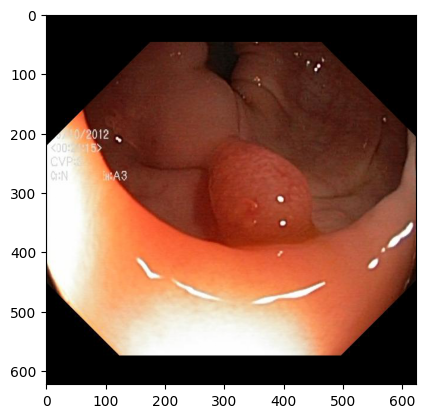

In [29]:
plt.imshow(asd[1].cpu().numpy().transpose(1,2,0))

tensor([[0.0000, 0.0000, 0.4692, 0.2791, 0.1240, 0.1254]])
tensor([[0.0000, 0.0000, 0.4414, 0.2056, 0.1559, 0.1575]])


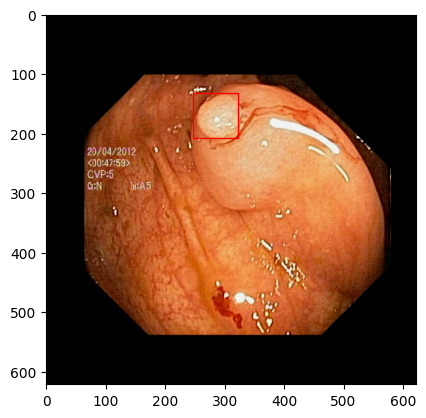

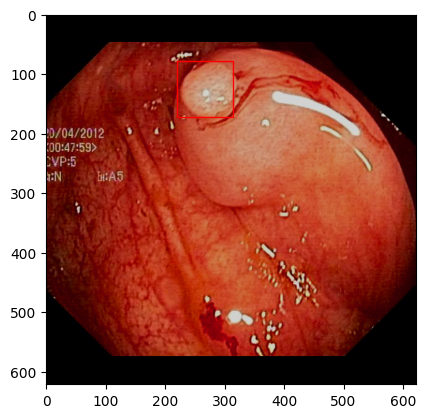

In [30]:
import matplotlib.patches as patches
def yolo2plt(yolo_c):
  yolo_c=yolo_c.numpy()
  x= ((yolo_c[2]-yolo_c[4]/2)*608).astype("int")
  y = ((yolo_c[3]-yolo_c[5]/2)*608).astype("int")
  w = (yolo_c[4]*608).astype("int")
  h = (yolo_c[5]*608).astype("int")
  return x,y,w,h
to_plot = 554
asd =datatrain[to_plot]#test validation dataset 
print(asd[2])
x,y,w,h = yolo2plt(asd[2][0])
fig, ax = plt.subplots()
ax.imshow(asd[1].cpu().numpy().transpose(1,2,0))
ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none'))

asd1 =datatrain[to_plot]#test validation dataset 

print(asd1[2])
x,y,w,h = yolo2plt(asd1[2][0])
fig, ax = plt.subplots()
ax.imshow(asd1[1].cpu().numpy().transpose(1,2,0))
ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none'))


In [31]:
batch_size = 8
trainloader = DataLoader(
        datatrain,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        collate_fn=datatrain.collate_fn,
       )

valiloader = DataLoader(
        datavali,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        collate_fn=datavali.collate_fn,
       )

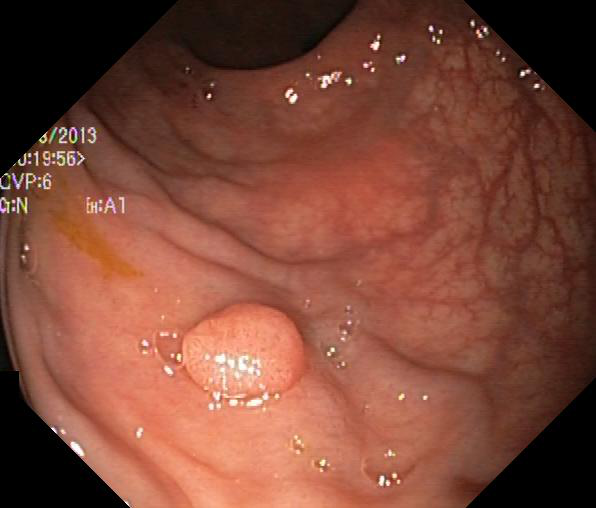

In [32]:
Image.open('/content/gdrive/MyDrive/Yolo_v3/Kvasir/data/Kvasir-SEG/images/cju88vx2uoocy075531lc63n3.jpg')

In [33]:
import torch.optim as optim
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(
            params,
            lr=1e-4)

In [34]:
import tqdm
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
max_epoch = 20

In [35]:
# first we need a metric to define how close 2 bboxes are. Many solutions are possible

In [36]:
import math
#loss function is based on https://github.com/ultralytics/yolov3/blob/master/utils/loss.py
def bbox_iou(box1, box2, x1y1x2y2=True, GIoU=False, DIoU=False, CIoU=False, eps=1e-9):
    # Returns the IoU of box1 to box2. box1 is 4, box2 is nx4
    box2 = box2.T

    # Get the coordinates of bounding boxes
    if x1y1x2y2:  # x1, y1, x2, y2 = box1
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]
    else:  # transform from xywh to xyxy
        b1_x1, b1_x2 = box1[0] - box1[2] / 2, box1[0] + box1[2] / 2
        b1_y1, b1_y2 = box1[1] - box1[3] / 2, box1[1] + box1[3] / 2
        b2_x1, b2_x2 = box2[0] - box2[2] / 2, box2[0] + box2[2] / 2
        b2_y1, b2_y2 = box2[1] - box2[3] / 2, box2[1] + box2[3] / 2

    # Intersection area
    inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
            (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)

    # Union Area
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps
    union = w1 * h1 + w2 * h2 - inter + eps

    iou = inter / union
    if GIoU or DIoU or CIoU:
        # convex (smallest enclosing box) width
        cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)
        ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height
        if CIoU or DIoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
            c2 = cw ** 2 + ch ** 2 + eps  # convex diagonal squared
            rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 +
                    (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4  # center distance squared
            if DIoU:
                return iou - rho2 / c2  # DIoU
            elif CIoU:  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
                v = (4 / math.pi ** 2) * \
                    torch.pow(torch.atan(w2 / h2) - torch.atan(w1 / h1), 2)
                with torch.no_grad():
                    alpha = v / ((1 + eps) - iou + v)
                return iou - (rho2 / c2 + v * alpha)  # CIoU
        else:  # GIoU https://arxiv.org/pdf/1902.09630.pdf
            c_area = cw * ch + eps  # convex area
            return iou - (c_area - union) / c_area  # GIoU
    else:
        return iou  # IoU

def to_cpu(tensor):
    return tensor.detach().cpu()

In [37]:
print(bbox_iou(asd[2][0][2:],asd1[2][0][2:],x1y1x2y2=False))#example computed on the bboxes of the printed transformation
print(bbox_iou(asd[2][0][2:],asd[2][0][2:],x1y1x2y2=False))# this is 1 by definition

tensor(0.2344)
tensor(1.0000)


<ipython-input-36-e63b7dfa57c8>:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  box2 = box2.T


In [38]:
asd[2][0][2:]#bboxes coordinates

tensor([0.4692, 0.2791, 0.1240, 0.1254])

In [39]:
# first step is check every anchor (3 anchors) to each possible target bbox (for each image)
# then do it at each possible scale (3 times) --> rescale to each different resolution
# iterate over targets

def build_targets(p, targets, model):
    # Build targets for compute_loss(), input targets(image,class,x,y,w,h)
    na, nt = 3, targets.shape[0]  # number of anchors, targets #TODO
    tcls, tbox, indices, anch = [], [], [], []
    gain = torch.ones(7, device=targets.device)  # normalized to gridspace gain
    # Make a tensor that iterates 0-2 for 3 anchors and repeat that as many times as we have target boxes
    ai = torch.arange(na, device=targets.device).float().view(na, 1).repeat(1, nt)
    # Copy target boxes anchor size times and append an anchor index to each copy the anchor index is also expressed by the new first dimension
    targets = torch.cat((targets.repeat(na, 1, 1), ai[:, :, None]), 2)

    for i, yolo_layer in enumerate(model.yolo_layers):
        # Scale anchors by the yolo grid cell size so that an anchor with the size of the cell would result in 1
        anchors = yolo_layer.anchors / yolo_layer.stride
        # Add the number of yolo cells in this layer the gain tensor
        # The gain tensor matches the collums of our targets (img id, class, x, y, w, h, anchor id)
        gain[2:6] = torch.tensor(p[i].shape)[[3, 2, 3, 2]]  # xyxy gain
        # Scale targets by the number of yolo layer cells, they are now in the yolo cell coordinate system
        t = targets * gain
        # Check if we have targets
        if nt:
            # Calculate ration between anchor and target box for both width and height
            r = t[:, :, 4:6] / anchors[:, None]
            # Select the ratios that have the highest divergence in any axis and check if the ratio is less than 4
            j = torch.max(r, 1. / r).max(2)[0] < 4  # compare #TODO
            # Only use targets that have the correct ratios for their anchors
            # That means we only keep ones that have a matching anchor and we loose the anchor dimension
            # The anchor id is still saved in the 7th value of each target
            t = t[j]
        else:
            t = targets[0]

        # Extract image id in batch and class id
        b, c = t[:, :2].long().T
        # We isolate the target cell associations.
        # x, y, w, h are allready in the cell coordinate system meaning an x = 1.2 would be 1.2 times cellwidth
        gxy = t[:, 2:4]
        gwh = t[:, 4:6]  # grid wh
        # Cast to int to get an cell index e.g. 1.2 gets associated to cell 1
        gij = gxy.long()
        # Isolate x and y index dimensions
        gi, gj = gij.T  # grid xy indices

        # Convert anchor indexes to int
        a = t[:, 6].long()
        # Add target tensors for this yolo layer to the output lists
        # Add to index list and limit index range to prevent out of bounds
        indices.append((b, a, gj.clamp_(0, gain[3].long() - 1), gi.clamp_(0, gain[2].long() - 1)))
        # Add to target box list and convert box coordinates from global grid coordinates to local offsets in the grid cell
        tbox.append(torch.cat((gxy - gij, gwh), 1))  # box
        # Add correct anchor for each target to the list
        anch.append(anchors[a])
        # Add class for each target to the list
        tcls.append(c)

    return tcls, tbox, indices, anch

In [40]:
tcls, tbox, indices, anch = build_targets(out, asd[2], model)#in: model output, target bbox (1), model output resolutions
#target class (for classification accuracy)
print("predicted classes")
print(tcls)
#target box (for classification accuracy)
print("predicted positions")
print(tbox)
print("\n corresponding ids on the outputs : image id\n anchor id,\n corresponding cell on the output\n" )
print(indices[0])
print(indices[1])

predicted classes
[tensor([0, 0]), tensor([0, 0, 0]), tensor([0])]
predicted positions
[tensor([[0.9152, 0.3032, 2.3569, 2.3822],
        [0.9152, 0.3032, 2.3569, 2.3822]]), tensor([[0.8305, 0.6064, 4.7137, 4.7644],
        [0.8305, 0.6064, 4.7137, 4.7644],
        [0.8305, 0.6064, 4.7137, 4.7644]]), tensor([[0.6610, 0.2128, 9.4275, 9.5288]])]

 corresponding ids on the outputs : image id
 anchor id,
 corresponding cell on the output

(tensor([0, 0]), tensor([0, 1]), tensor([5, 5]), tensor([8, 8]))
(tensor([0, 0, 0]), tensor([0, 1, 2]), tensor([10, 10, 10]), tensor([17, 17, 17]))


In [41]:
# we have 3 loss components
# clssification of the objec (trivial in our case)
# localization of the object
# bounding box prediction


def compute_loss(predictions, targets, model):
    # Check which device was used
    device = targets.device

    # Add placeholder varables for the different losses
    lcls, lbox, lobj = torch.zeros(1, device=device), torch.zeros(1, device=device), torch.zeros(1, device=device)# 3 real numbers

    # Build yolo targets
    tcls, tbox, indices, anchors = build_targets(predictions, targets, model)  # targets

    # Define different loss functions classification
    BCEcls = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([1.0], device=device))
    BCEobj = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([1.0], device=device))

    # Calculate losses for each yolo layer (the 3 resolutons)
    for layer_index, layer_predictions in enumerate(predictions):
        # Get image ids, anchors, grid index i and j for each target in the current yolo layer
        b, anchor, grid_j, grid_i = indices[layer_index]
        # Build empty object target tensor with the same shape as the object prediction
        tobj = torch.zeros_like(layer_predictions[..., 0], device=device)  # target obj
        # Get the number of targets for this layer.
        # Each target is a label box with some scaling and the association of an anchor box.
        # Label boxes may be associated to 0 or multiple anchors. So they are multiple times or not at all in the targets.
        num_targets = b.shape[0]
        # Check if there are targets for this batch
        if num_targets:
            # Load the corresponding values from the predictions for each of the targets
            ps = layer_predictions[b, anchor, grid_j, grid_i]#the image in the batch, the anchor, the position on the grid

            # Regression of the box
            # Apply sigmoid to xy offset predictions in each cell that has a target
            pxy = ps[:, :2].sigmoid()#-->linear to logit (respect to the anchor)
            # Apply exponent to wh predictions and multiply with the anchor box that matched best with the label for each cell that has a target
            pwh = torch.exp(ps[:, 2:4]) * anchors[layer_index]#--->
            # Build box out of xy and wh
            pbox = torch.cat((pxy, pwh), 1)
            # Calculate CIoU or GIoU for each target with the predicted box for its cell + anchor
            iou = bbox_iou(pbox.T, tbox[layer_index], x1y1x2y2=False, CIoU=True)
            # We want to minimize our loss so we and the best possible IoU is 1 so we take 1 - IoU and reduce it with a mean
            lbox += (1.0 - iou).mean()  # iou loss

            # Classification of the objectness
            # Fill our empty object target tensor with the IoU we just calculated for each target at the targets position
            tobj[b, anchor, grid_j, grid_i] = iou.detach().clamp(0).type(tobj.dtype)  # Use cells with iou > 0 as object targets

            # Classification of the class
            # Check if we need to do a classification (number of classes > 1)
            if ps.size(1) - 5 > 1:
                # Hot one class encoding
                t = torch.zeros_like(ps[:, 5:], device=device)  # targets
                t[range(num_targets), tcls[layer_index]] = 1
                # Use the tensor to calculate the BCE loss
                lcls += BCEcls(ps[:, 5:], t)  # BCE

        # Classification of the objectness the sequel
        # Calculate the BCE loss between the on the fly generated target and the network prediction
        lobj += BCEobj(layer_predictions[..., 4], tobj) # obj loss

    lbox *= 0.05
    lobj *= 1.0
    lcls *= 0.5

    # Merge losses
    loss = lbox + lobj + lcls

    return loss, to_cpu(torch.cat((lbox, lobj, lcls, loss)))





In [42]:
loss,components = compute_loss(out, asd[2], model)#in: model output, target bbox (1), model output resolutions

In [43]:
print(loss.detach().cpu())
print(components)#box, object, classification, total

tensor([1.5094])
tensor([0.1162, 1.3932, 0.0000, 1.5094])


In [ ]:
for epoch in range(1, max_epoch+1):

        print("\n---- Training Model ----")

        model.train()  # Set model to training mode

        for batch_i, (_, imgs, targets) in enumerate(tqdm.tqdm(trainloader, desc=f"Training Epoch {epoch}")):
            batches_done = len(trainloader) * epoch + batch_i

            imgs = imgs.to(device, non_blocking=True)
            targets = targets.to(device)

            outputs = model(imgs)

            loss, loss_components = compute_loss(outputs, targets, model)
            print(loss.detach().cpu().numpy())

            loss.backward()

            ###############
            # Run optimizer
            ###############

            

            # Run optimizer
            optimizer.step()
            # Reset gradients
            optimizer.zero_grad()

        


---- Training Model ----


Training Epoch 1:   0%|          | 0/113 [00:00<?, ?it/s]

[1.5199531]


Training Epoch 1:   1%|          | 1/113 [02:07<3:57:14, 127.09s/it]

In [ ]:
print(str(np.sort((centroids*608).astype("int"),axis=0)).replace("[","").replace("]","").replace("  ",",").replace("  ",",").replace("\n",",   "))